<center><h1> Darknet traffic dataset </h1> </center>

# Libraries importing and configuration

In [599]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipinfo
import json

from category_encoders.hashing import HashingEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [162]:
ipinfo_handler = ipinfo.getHandler("de30fe3213f197")

random_state = 42
dataset_folder = "dataset/" 

pd.options.mode.chained_assignment = None  # default='warn'
np.random.seed(random_state)
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams.update({'font.size': 15})

In [163]:
data = pd.read_csv(dataset_folder + "Darknet.CSV", low_memory=False)

# Dataset processing

## Labels duplicates correction

In [214]:
samples = data.copy()

traffic_labels = samples["Label"].unique()
print(traffic_labels)
traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Non-Tor' 'NonVPN' 'Tor' 'VPN']
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [215]:
samples['Label.1'].loc[samples['Label.1'] == 'AUDIO-STREAMING'] = 'Audio-Streaming'
samples['Label.1'].loc[samples['Label.1'] == 'File-transfer'] = 'File-Transfer'
samples['Label.1'].loc[samples['Label.1'] == 'Video-streaming'] = 'Video-Streaming'

traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Audio-Streaming' 'Browsing' 'Chat' 'Email' 'File-Transfer' 'P2P'
 'Video-Streaming' 'VOIP']


## Labels grouping in Benign and Darknet

In [216]:
samples['Label'].loc[(samples['Label'] == 'Non-Tor') | (samples['Label'] == 'NonVPN')] = 'Benign'
samples['Label'].loc[(samples['Label'] == 'Tor') | (samples['Label'] == 'VPN')] = 'Darknet'

traffic_labels = samples["Label"].unique()
print(traffic_labels)

['Benign' 'Darknet']


## Timestamp feature extraction

In [217]:
hours = []
for timestamp in samples['Timestamp']:
    hora = int(timestamp.split()[1].split(':')[0])
    hours.append(hora)
samples['hour'] = hours
print(samples[['Timestamp', 'hour']][:5])

                Timestamp  hour
0  24/07/2015 04:09:48 PM     4
1  24/07/2015 04:09:48 PM     4
2  24/07/2015 04:09:48 PM     4
3  24/07/2015 04:09:48 PM     4
4  24/07/2015 04:09:45 PM     4


## Source and destination ips feature extraction

### 1-gram, 2-gram and 3-gram extraction

In [218]:
def create_grams(ip):
    parts = ip.split('.')
    one_gram = parts[0]
    two_gram = parts[0] + " " + parts[1]
    three_gram = parts[0] + " " + parts[1] + " " + parts[2]
    return one_gram, two_gram, three_gram

In [219]:
src_one_gram = []
src_two_gram = []
src_three_gram = []
dst_one_gram = []
dst_two_gram = []
dst_three_gram = []

for src_ip, dst_ip in zip(samples["Src IP"], samples["Dst IP"]): 
    src_one, src_two, src_three = create_grams(src_ip)
    src_one_gram.append(src_one)
    src_two_gram.append(src_two)
    src_three_gram.append(src_three)
    dst_one, dst_two, dst_three = create_grams(dst_ip)
    dst_one_gram.append(dst_one)
    dst_two_gram.append(dst_two)
    dst_three_gram.append(dst_three)

samples["src_ip_1gram"] = src_one_gram
samples["src_ip_2gram"] = src_two_gram
samples["src_ip_3gram"] = src_three_gram

samples["dst_ip_1gram"] = dst_one_gram
samples["dst_ip_2gram"] = dst_two_gram
samples["dst_ip_3gram"] = dst_three_gram

#print(samples[["Src IP","src_ip_1gram","src_ip_2gram","src_ip_3gram"]][200:205])
#print(samples[["Dst IP","dst_ip_1gram","dst_ip_2gram","dst_ip_3gram"]][:5])

### Ips details extraction

In [220]:
def get_ip_detail(ip, ip_dict, repeated):
    if ip not in ip_dict.keys():
        details = ipinfo_handler.getDetails(ip)
        ip_dict[ip] = details.all
    else:
        repeated += 1
    return repeated

def dump_ips(ip_dict, folder):
    j = json.dumps(ip_dict)
    f = open(folder+"ips_dict.json","w")
    f.write(j)
    f.close()

def load_ips(file):
    data = {}
    with open(file) as json_file:
        data = json.load(json_file)
    return data

In [221]:
ip_dict = load_ips("ips_dict.json")

In [222]:
ips = np.concatenate((samples["Src IP"].unique(), samples["Dst IP"].unique())) 
for i in tqdm(range(len(ips))):
    get_ip_detail(ips[i], ip_dict, 0)
dump_ips(ip_dict, "")

100%|██████████| 11111/11111 [00:00<00:00, 363826.59it/s]


In [223]:
ips_tuple = zip(samples["Src IP"], samples["Dst IP"])
dst_ip_country = []
src_ip_country = []
src_bogon = []
dst_bogon = []

for src_ip, dst_ip in tqdm(ips_tuple, total=len(samples["Src IP"])):
    if 'country' in ip_dict[dst_ip].keys():
        dst_ip_country.append(ip_dict[dst_ip]['country'])
    else:
        dst_ip_country.append("")
    if 'country' in ip_dict[src_ip].keys():
        src_ip_country.append(ip_dict[src_ip]['country'])
    else:
        src_ip_country.append("")
    if 'bogon' in ip_dict[dst_ip].keys():
        dst_bogon.append(ip_dict[dst_ip]['bogon'])
    else:
        dst_bogon.append(False)
    if 'bogon' in ip_dict[src_ip].keys():
        src_bogon.append(ip_dict[src_ip]['bogon'])
    else:
        src_bogon.append(False)
samples['src_ip_country'] = src_ip_country
samples['dst_ip_country'] = dst_ip_country
samples['src_bogon'] = src_bogon
samples['dst_bogon'] = dst_bogon

100%|██████████| 141530/141530 [00:00<00:00, 254606.48it/s]


## Irrelevant attributes extraction

In [495]:
model_samples = samples.copy()

del model_samples['Flow ID']
del model_samples['Timestamp']
del model_samples['Src IP']
del model_samples['Dst IP']

In [496]:
cols = np.concatenate((model_samples.columns[81:], model_samples.columns[:81]))
model_samples = model_samples[cols]

In [497]:
model_samples.columns

Index(['hour', 'src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram',
       'dst_ip_2gram', 'dst_ip_3gram', 'src_ip_country', 'dst_ip_country',
       'src_bogon', 'dst_bogon', 'Src Port', 'Dst Port', 'Protocol',
       'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Pac

## Categorical features encoding

In [498]:
hash_enc_cols = cols[1:7]
print(hash_enc_cols)
ord_enc_cols = ['src_ip_country','dst_ip_country']
print(ord_enc_cols)
one_hot_enc_cols = ['Label.1']
print(one_hot_enc_cols)

['src_ip_1gram' 'src_ip_2gram' 'src_ip_3gram' 'dst_ip_1gram'
 'dst_ip_2gram' 'dst_ip_3gram']
['src_ip_country', 'dst_ip_country']
['Label.1']


In [499]:
hash_enc = HashingEncoder(cols=hash_enc_cols, n_components=100).fit(model_samples)
model_samples = hash_enc.transform(model_samples)
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign,Audio-Streaming


In [500]:
ord_enc = OrdinalEncoder()
ord_enc.fit(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = ord_enc.transform(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = model_samples[ord_enc_cols].astype(int)
model_samples[ord_enc_cols].head() 

,src_ip_country,dst_ip_country
0,0,134
1,0,134
2,0,134
3,0,134
4,0,134


In [501]:
model_samples_l1 = model_samples[model_samples['Label'] == "Darknet"].copy()
del model_samples['Label.1']
del model_samples_l1['Label']
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
1,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
2,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
3,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
4,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign


In [502]:
model_samples_l1.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
       'Label.1'],
      dtype='object', length=185)

In [503]:
model_samples.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label'],
      dtype='object', length=185)

In [504]:
model_samples = model_samples.replace([np.inf, -np.inf], np.nan)
model_samples_l1 = model_samples_l1.replace([np.inf, -np.inf], np.nan)

In [505]:
model_samples = model_samples.dropna()
model_samples_l1 = model_samples_l1.dropna()
len(model_samples)

141483

## Numerical features scaling

In [337]:
real_columns = model_samples.columns[108:-9]
real_columns

Index(['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag C

In [506]:
model_samples[real_columns] = model_samples[real_columns].astype(np.float64)
model_samples[real_columns] = model_samples[real_columns].replace([np.inf, -np.inf], np.nan)
model_samples[real_columns].dropna()

model_samples_l1[real_columns] = model_samples_l1[real_columns].astype(np.float64)
model_samples_l1[real_columns] = model_samples_l1[real_columns].replace([np.inf, -np.inf], np.nan)
model_samples_l1[real_columns].dropna()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
117219,119384497.0,767.0,2027.0,90681.0,2448831.0,543.0,0.0,118.228162,224.244409,1420.0,...,336.0,150679.0,0.0,32.0,0.0,876.0,65535.0,65535.0,166.0,20.0
117220,119754701.0,1021.0,2537.0,171290.0,2922270.0,1460.0,0.0,167.766895,280.092409,1420.0,...,421.0,94293.0,0.0,48.0,0.0,821.0,65535.0,65535.0,292.0,20.0
117221,118908117.0,683.0,1662.0,77649.0,2001627.0,543.0,0.0,113.688141,221.086482,1420.0,...,275.0,168275.0,0.0,33.0,0.0,853.0,65535.0,65535.0,142.0,20.0
117222,739728.0,2.0,2.0,543.0,543.0,543.0,0.0,271.500000,383.958982,543.0,...,0.0,0.0,0.0,135.0,0.0,135.0,41180.0,65535.0,0.0,20.0
117223,149270.0,2.0,2.0,565.0,565.0,565.0,0.0,282.500000,399.515331,565.0,...,0.0,0.0,0.0,141.0,0.0,141.0,41180.0,65535.0,0.0,20.0
117224,11718197.0,3.0,4.0,1086.0,543.0,543.0,0.0,362.000000,313.501196,543.0,...,0.0,0.0,0.0,155.0,0.0,77.0,41180.0,65535.0,1.0,20.0
117225,115909057.0,783.0,1963.0,88277.0,2404390.0,1057.0,0.0,112.742018,232.654722,1420.0,...,326.0,191604.0,0.0,32.0,0.0,875.0,65535.0,65535.0,154.0,20.0
117226,3465904.0,14.0,18.0,4887.0,5401.0,543.0,0.0,349.071429,270.004121,1057.0,...,18.0,2968.0,0.0,152.0,0.0,168.0,41811.0,65535.0,8.0,20.0
117227,112024262.0,797.0,1682.0,84961.0,2022224.0,1460.0,0.0,106.601004,230.441054,1420.0,...,208.0,140065.0,0.0,34.0,0.0,815.0,65535.0,65535.0,147.0,20.0
117228,9993461.0,3.0,3.0,1130.0,565.0,565.0,0.0,376.666667,326.202902,565.0,...,0.0,0.0,0.0,188.0,0.0,94.0,41180.0,65535.0,1.0,20.0


In [507]:
df1 = model_samples[model_samples.isna().any(axis=1)]
model_samples = model_samples.drop(df1.index)

df1 = model_samples_l1[model_samples_l1.isna().any(axis=1)]
model_samples_l1 = model_samples_l1.drop(df1.index)

In [508]:
scaler = StandardScaler().fit(model_samples[real_columns])
model_samples[real_columns] = scaler.transform(model_samples[real_columns])
model_samples_l1[real_columns] = scaler.transform(model_samples_l1[real_columns])

In [509]:
model_samples[real_columns].head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
0,-0.546508,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.345303,-0.095141,-0.061219,0.589647
1,-0.546503,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.335704,-0.095141,-0.061219,0.589647
2,-0.546502,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.329439,-0.095141,-0.061219,0.589647
3,-0.546504,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.333582,-0.095141,-0.061219,0.589647
4,-0.263585,0.184194,0.071741,-0.014801,-0.027116,-0.120075,-0.498852,0.179861,-0.247304,0.340530,...,0.164343,-0.036900,-0.634075,0.158678,0.0,-0.368398,-0.396835,0.073134,0.305786,0.589647


## Processed dataset

In [42]:
print(samples.columns[:5])
print(f"Number of features: {len(samples.columns)}")

Index(['hour', 'src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram'], dtype='object')
Number of features: 92


In [43]:
samples.dtypes[:40]

hour                            int64
src_ip_1gram                   object
src_ip_2gram                   object
src_ip_3gram                   object
dst_ip_1gram                   object
dst_ip_2gram                   object
dst_ip_3gram                   object
src_ip_country                 object
dst_ip_country                 object
src_bogon                        bool
dst_bogon                        bool
Src Port                        int64
Dst Port                        int64
Protocol                        int64
Flow Duration                   int64
Total Fwd Packet                int64
Total Bwd packets               int64
Total Length of Fwd Packet      int64
Total Length of Bwd Packet      int64
Fwd Packet Length Max           int64
Fwd Packet Length Min           int64
Fwd Packet Length Mean        float64
Fwd Packet Length Std         float64
Bwd Packet Length Max           int64
Bwd Packet Length Min           int64
Bwd Packet Length Mean        float64
Bwd Packet L

In [ ]:
samples.dtypes[40:81]

In [ ]:
samples.dtypes[81:]

In [ ]:
samples.to_csv(dataset_folder+"darknet_processado.csv")
samples.head()

# Dataset analysis

In [60]:
cols=["hour", "Label", "Label.1"]
to_analyse = samples[cols]
to_analyse.head()

,hour,Label,Label.1
0,4,Benign,Audio-Streaming
1,4,Benign,Audio-Streaming
2,4,Benign,Audio-Streaming
3,4,Benign,Audio-Streaming
4,4,Benign,Audio-Streaming


## Labels probability distribution

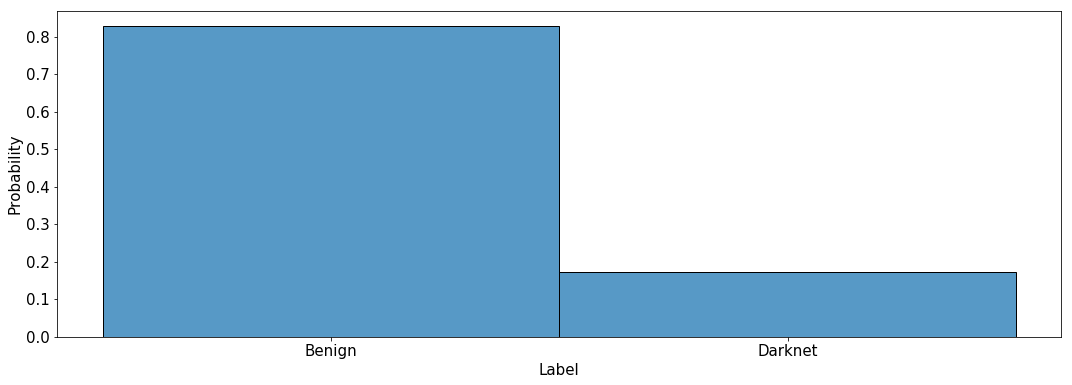

In [220]:
sns.histplot(data=to_analyse, x="Label", stat="probability")
plt.show()

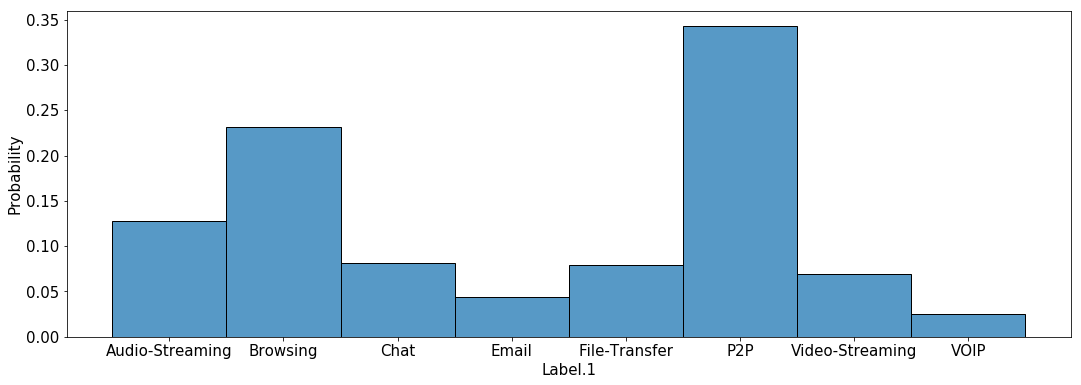

In [221]:
sns.histplot(data=to_analyse, x="Label.1", stat="probability")
plt.show()

## Traffic type on Darknet and outside

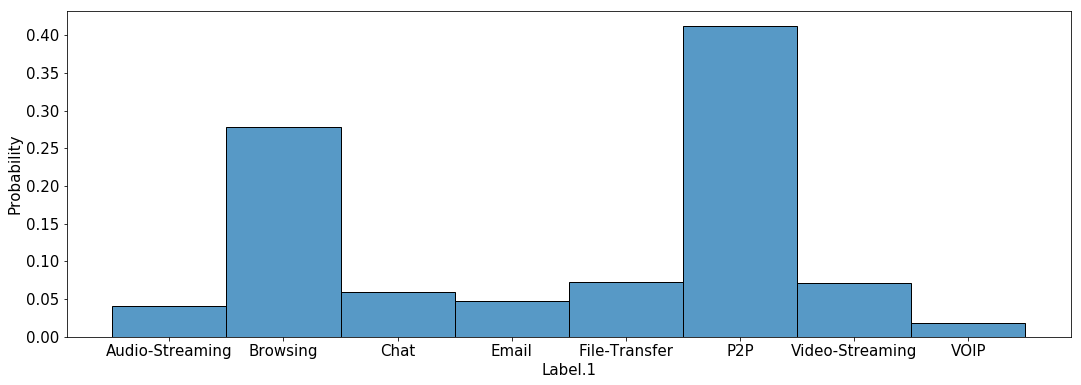

In [222]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Benign"], x="Label.1", stat="probability")
plt.show()

In [ ]:
to_analyse[to_analyse['Label'] == "Benign"]['Label.1'].hist(cumulative=True, density=1, bins=8, grid=True)
plt.show()

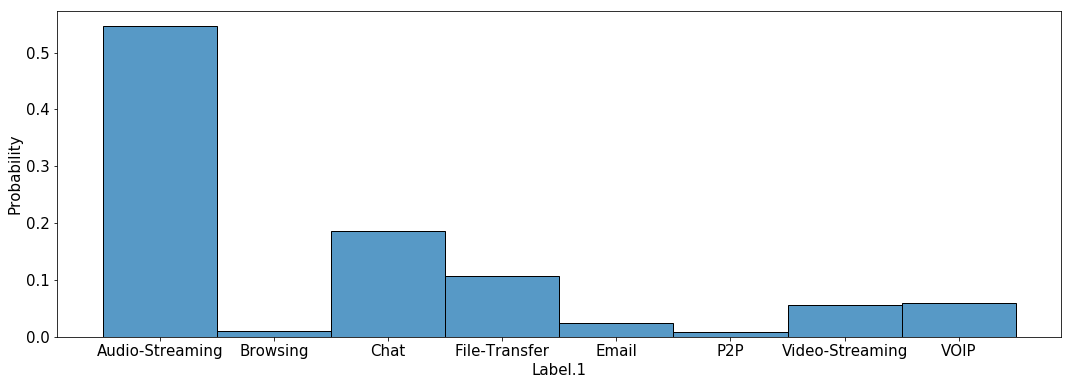

In [63]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Darknet"], x="Label.1", stat="probability")
plt.show()

In [ ]:
to_analyse[to_analyse['Label'] == "Darknet"]['Label.1'].hist(cumulative=True, density=1, bins=8, grid=True)
plt.show()

## Access hour

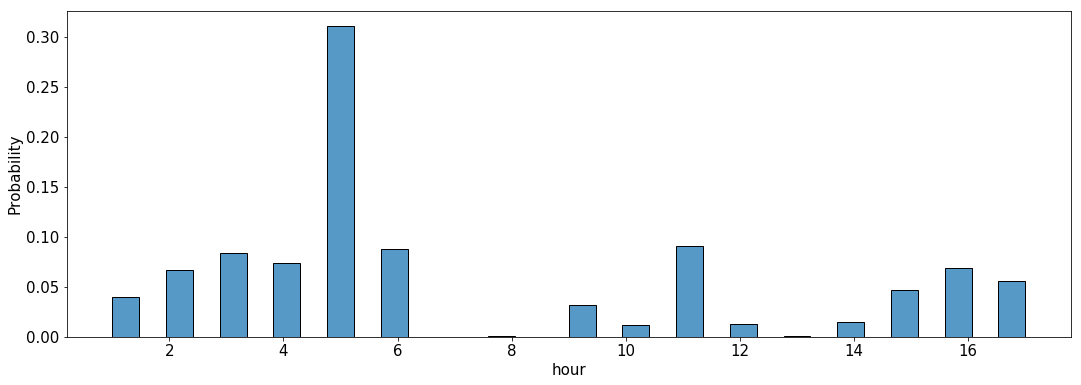

In [61]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Darknet"], x="hour", stat="probability")
plt.show()

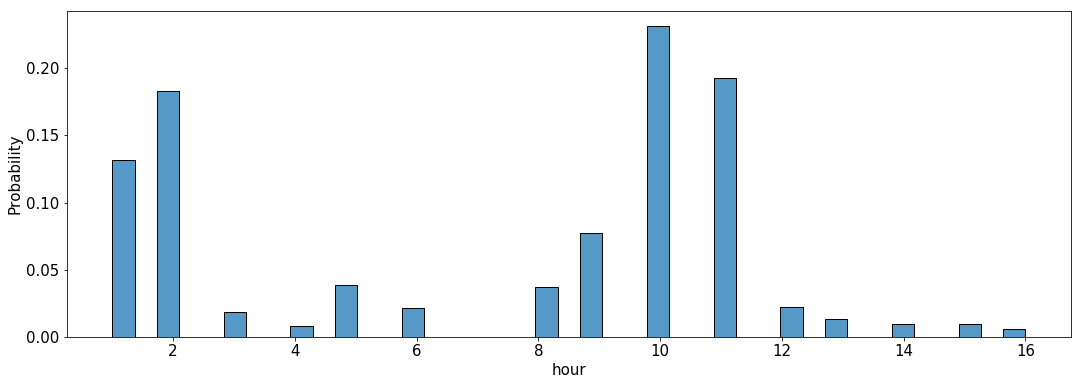

In [62]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Benign"], x="hour", stat="probability")
plt.show()

# Models evaluation

In [520]:
def split_train_target(samples, labels_col):
    X = samples.copy()
    del X[labels_col]
    X = X.values
    y = samples[labels_col].values
    labels = np.unique(samples[labels_col])
    return X, y, labels

In [342]:
def kfold_validation(model, X, y, labels=None, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    classifier_reports = []
    for train_index, test_index in tqdm(skf.split(X, y), total=n_splits): 
        x_train_fold, x_test_fold = X[train_index], X[test_index] 
        y_train_fold, y_test_fold = y[train_index], y[test_index] 
        model = model.fit(x_train_fold,y_train_fold)
        y_pred_fold = model.predict(x_test_fold)
        class_report = classification_report(y_test_fold, y_pred_fold, target_names=labels,
                                             output_dict=True)    
        classifier_reports.append(class_report)
    
    final_report = {}
    for report in classifier_reports:
        for label in report.keys():
            if type(report[label]) == dict:
                if label not in final_report:
                    final_report[label] = {}
                for key in report[label].keys():
                    if key not in final_report[label]:
                            final_report[label][key] = 0.0
                    final_report[label][key] += report[label][key]
            else:
                if label not in final_report:
                    final_report[label] = 0.0
                final_report[label] += report[label]

    for label in final_report.keys():
        if type(final_report[label]) == dict:
            for metric in final_report[label].keys():
                final_report[label][metric] /= n_splits
        else:
            final_report[label] /= n_splits
    final_report["n_splits"] = n_splits
    return final_report

In [343]:
def show_kfold_report(report, labels):
    metrics_printed = False
    n_spaces = max([len(label) for label in labels])
    for label in labels:
        if not metrics_printed:
            print(" "*n_spaces, end='')
            for metric in report[label].keys():
                print(f"{metric}", " "*6,end='')
            metrics_printed = True
            print()
        print(f"{label}: ", " "*(n_spaces-len(label)),end='')
        for metric in report[label].keys():
            print("%0.2f\t\t"%(report[label][metric]*100),end='')
        print()
    print("\n\n", "%d-fold Accuracy: %0.2f%%"%(report["n_splits"],report['accuracy']*100))

In [344]:
def show_confusion_matrix(model, X, y, labels):
    y_pred = model.predict(X)
    conf = confusion_matrix(y, y_pred)
    n_spaces = max([len(label) for label in labels])
    print("Test accuracy: %0.2f%%\n"%(np.sum((y_pred==y))/y.size*100))
    print("\nConfusion matrix:")
    print(conf)
    print()
    for i in range(conf.shape[0]):
        print(labels[i],":"," "*(n_spaces- len(labels[i])) ," %0.2f%%"%(conf[i,i]/np.sum(conf[i,:])*100))

In [627]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels, n_splits=10, figsize=(10,10)):
    kfold_report = kfold_validation(model, X_train, y_train, n_splits=n_splits)
    show_kfold_report(kfold_report, labels)
    show_confusion_matrix(model, X_test, y_test, labels)
    fig, ax = plt.subplots(figsize=figsize)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    return kfold_report

## Benign vs Darknet classification

In [569]:
X, y, labels = split_train_target(model_samples, "Label")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
columns = model_samples_l1.columns.tolist()

### Decision tree

100%|██████████| 10/10 [01:36<00:00,  9.68s/it]


       precision       recall       f1-score       support       
Benign:   99.94		99.92		99.93		784910.00		
Darknet:  99.64		99.71		99.67		163010.00		


 10-fold Accuracy: 99.89%
Test accuracy: 99.91%


Confusion matrix:
[[38661    18]
 [   22  7988]]

Benign :    99.95%
Darknet :   99.73%


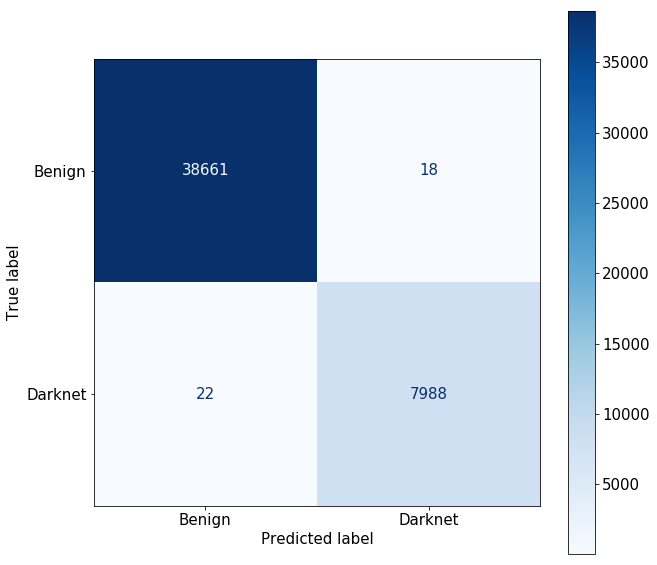

In [628]:
model = DecisionTreeClassifier(random_state=random_state)
report = evaluate_model(model, X_train, y_train, X_test, y_test, labels)

### Random forest

100%|██████████| 10/10 [05:23<00:00, 32.37s/it]


       precision       recall       f1-score       support       
Benign:   99.89		99.97		99.93		784910.00		
Darknet:  99.87		99.47		99.67		163010.00		


 10-fold Accuracy: 99.89%
Test accuracy: 99.90%


Confusion matrix:
[[38670     9]
 [   36  7974]]

Benign :    99.98%
Darknet :   99.55%


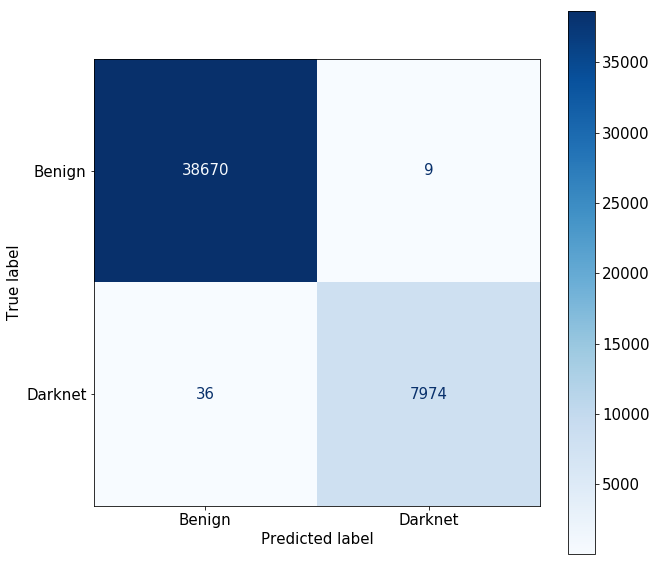

In [629]:
rf_model = RandomForestClassifier(random_state=random_state)
report_rf = evaluate_model(rf_model, X_train, y_train, X_test, y_test, labels)

## Darknet traffic caracterization

In [632]:
X1, y1, labels1 = split_train_target(model_samples_l1, "Label.1")
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=random_state)
columns1 = model_samples_l1.columns.tolist()

### Decision tree

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


               precision       recall       f1-score       support       
Audio-Streaming:  99.60		99.66		99.63		88830.00		
Browsing:         93.05		83.82		87.85		1750.00		
Chat:             98.93		99.28		99.10		30520.00		
Email:            95.33		95.70		95.45		3930.00		
File-Transfer:    98.27		97.92		98.09		17300.00		
P2P:              97.12		96.25		96.48		1570.00		
VOIP:             97.39		97.97		97.68		9860.00		
Video-Streaming:  96.28		96.16		96.21		9120.00		


 10-fold Accuracy: 98.81%
Test accuracy: 99.03%


Confusion matrix:
[[4387    2   12    0    0    0    0    0]
 [   4   80    0    0    1    1    1    1]
 [   5    4 1479    0    0    0    1    0]
 [   0    0    0  184    5    0    0    0]
 [   1    0    0   11  864    0    0    4]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   2    0    1    0    4    2   10  415]]

Audio-Streaming :   99.68%
Browsing :          90.91%
Chat :              99.33%
Email :             97.35%
File-Tr

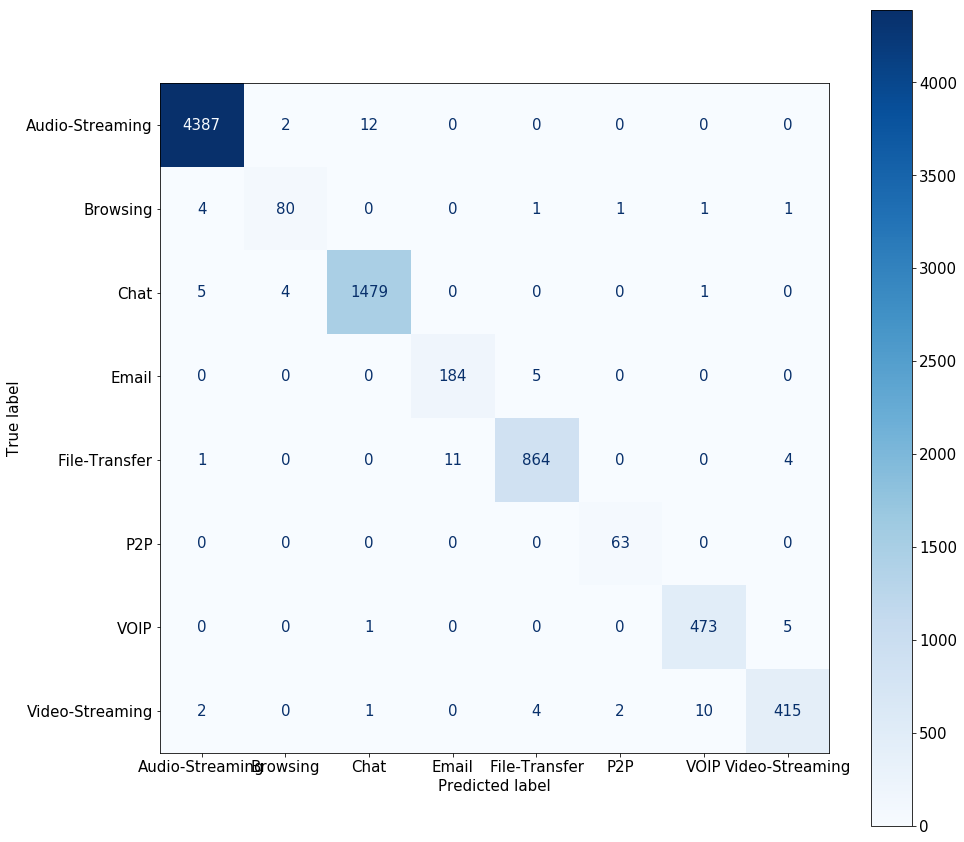

In [635]:
model1 = DecisionTreeClassifier(random_state=random_state)
report1 = evaluate_model(model1, X1_train, y1_train, X1_test, y1_test, labels1, figsize=(15,15))

### Random forest

100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


               precision       recall       f1-score       support       
Audio-Streaming:  99.50		99.08		99.29		88830.00		
Browsing:         88.49		83.95		85.87		1750.00		
Chat:             98.51		99.08		98.79		30520.00		
Email:            98.47		95.94		97.15		3930.00		
File-Transfer:    98.03		96.99		97.50		17300.00		
P2P:              95.67		97.50		96.32		1570.00		
VOIP:             97.13		97.26		97.16		9860.00		
Video-Streaming:  91.32		96.27		93.71		9120.00		


 10-fold Accuracy: 98.34%
Test accuracy: 98.34%


Confusion matrix:
[[4361    2   17    0    6    0    0   15]
 [   6   75    4    0    0    0    1    2]
 [   9    3 1462    0   14    0    0    1]
 [   0    0    1  185    3    0    0    0]
 [  10    0    5    4  859    0    0    2]
 [   2    0    0    0    0   61    0    0]
 [   2    1    1    0    1    0  468    6]
 [   1    2    0    0    2    0   10  419]]

Audio-Streaming :   99.09%
Browsing :          85.23%
Chat :              98.19%
Email :             97.88%
File-Tr

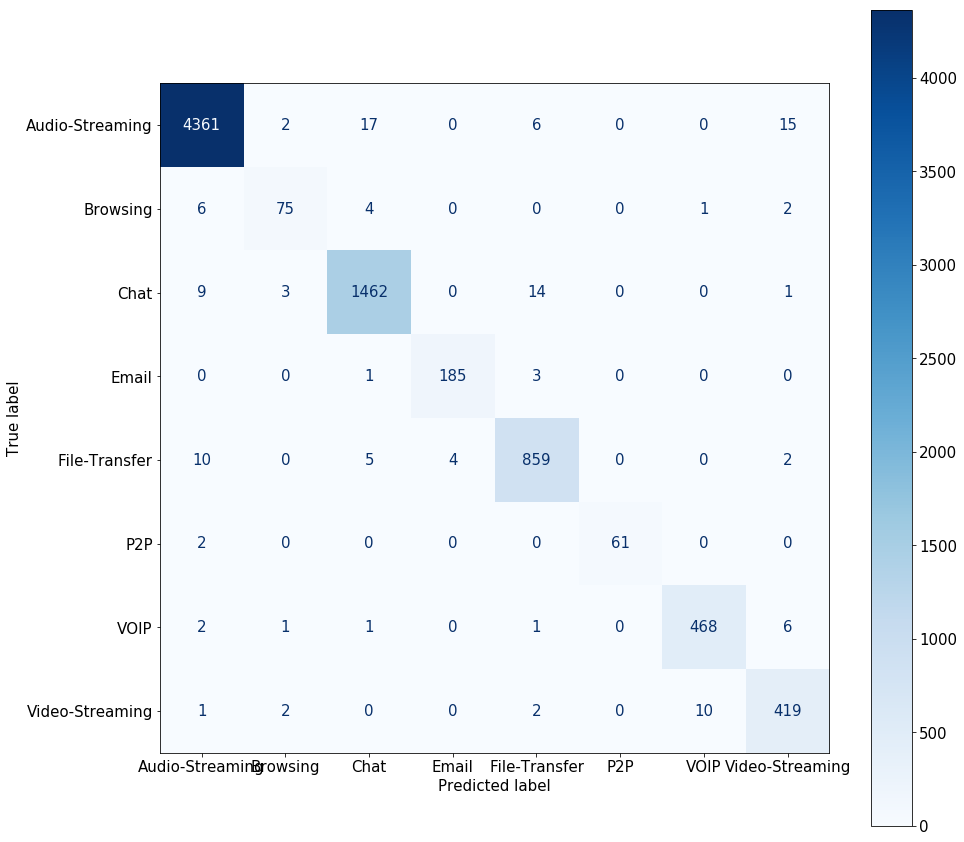

In [634]:
rf_model1 = RandomForestClassifier(random_state=random_state)
report_rf1 = evaluate_model(rf_model1, X1_train, y1_train, X1_test, y1_test, labels1, figsize=(15,15))

# Feature selection

## Recursive Feature Elimination (RFE)

In [591]:
def select_features(model, X, y, min_feats=1,step=2, random_state=None):
    rfe = RFECV(model, min_features_to_select=min_feats, step=step, cv=StratifiedKFold(10, shuffle=True, random_state=random_state), scoring='accuracy', n_jobs=4, verbose=3)
    rfe.fit(X, y)
    return rfe

def final_evaluation(model, X, y, labels, rfe):
    X_selected = rfe.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=random_state)
    kfold_report = kfold_validation(model, X_train, y_train, n_splits=10)
    show_kfold_report(kfold_report, np.unique(y_train))
    show_confusion_matrix(model, X_test, y_test, labels)

In [572]:
def summarize_feats(rfe, model, columns, to_remove=[]):
    columns = [column for column in columns if column not in to_remove]
    columns = [columns[i] for i in range(len(columns)) if (i < len(rfe.support_)) 
               and rfe.support_[i] ]
    features = zip(columns, model.feature_importances_)
    feat_import = [(feat, importance) for feat, importance in features]
    feat_import.sort(key = lambda x: x[1], reverse=True)
    
    n_spaces = max([len(feat) for feat, _ in feat_import[:25]])
    head = "Feature" + str(" "*(n_spaces-len("Feature")) + "\tImportance") 
    print(head)
    print("-"*(len(head)+5))
    for feature, importance in feat_import[:25]:
        print(f"%s:"%(feature)," "*(n_spaces-len(feature)),"\t%0.4f"%(importance))
    
    return columns

### Benign vs Darknet classification

#### Decision tree

In [573]:
model = DecisionTreeClassifier(random_state=random_state)
rfe = select_features(model, X, y, 10, step=4)

Fitting estimator with 184 features.
Fitting estimator with 180 features.
Fitting estimator with 176 features.
Fitting estimator with 172 features.
Fitting estimator with 168 features.
Fitting estimator with 164 features.
Fitting estimator with 160 features.
Fitting estimator with 156 features.
Fitting estimator with 152 features.
Fitting estimator with 148 features.
Fitting estimator with 144 features.
Fitting estimator with 140 features.
Fitting estimator with 136 features.
Fitting estimator with 132 features.
Fitting estimator with 128 features.
Fitting estimator with 124 features.
Fitting estimator with 120 features.
Fitting estimator with 116 features.
Fitting estimator with 112 features.
Fitting estimator with 108 features.
Fitting estimator with 104 features.
Fitting estimator with 100 features.
Fitting estimator with 96 features.
Fitting estimator with 92 features.
Fitting estimator with 88 features.
Fitting estimator with 84 features.
Fitting estimator with 80 features.
Fittin

In [575]:
print(f"Optimal number of features: {rfe.n_features_}")
selected_columns = summarize_feats(rfe, model, columns)

Optimal number of features: 32
Feature               	Importance
--------------------------------------
col_91:                  	0.7628
col_49:                  	0.1205
Bwd Init Win Bytes:      	0.0418
col_24:                  	0.0408
hour:                    	0.0152
col_96:                  	0.0034
Idle Min:                	0.0025
Idle Std:                	0.0021
col_45:                  	0.0018
Idle Max:                	0.0014
Flow IAT Min:            	0.0012
col_1:                   	0.0009
Src Port:                	0.0008
FIN Flag Count:          	0.0008
Packet Length Variance:  	0.0005
FWD Init Win Bytes:      	0.0004
Flow IAT Mean:           	0.0004
col_29:                  	0.0003
Packet Length Min:       	0.0003
col_80:                  	0.0002
Bwd Packets/s:           	0.0002
Flow Bytes/s:            	0.0002
Fwd IAT Min:             	0.0002
Flow Duration:           	0.0002
Fwd PSH Flags:           	0.0002


In [574]:
final_report = final_evaluation(model, X, y, labels, rfe)

100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


       precision       recall       f1-score       support       
Benign:   99.94		99.92		99.93		784910.00		
Darknet:  99.63		99.69		99.66		163010.00		


 10-fold Accuracy: 99.88%
Test accuracy: 99.92%


Confusion matrix:
[[38659    20]
 [   19  7991]]

Benign :    99.95%
Darknet :   99.76%


In [577]:
dotfile = open("dtree3.dot", 'w')
export_graphviz(model, out_file = dotfile, feature_names = selected_columns)
dotfile.close()

#### Random forest

In [578]:
model_rf = DecisionTreeClassifier(random_state=random_state)
rfe_rf = select_features(model_rf, X, y, 1, step=4)

Fitting estimator with 184 features.
Fitting estimator with 180 features.
Fitting estimator with 176 features.
Fitting estimator with 172 features.
Fitting estimator with 168 features.
Fitting estimator with 164 features.
Fitting estimator with 160 features.
Fitting estimator with 156 features.
Fitting estimator with 152 features.
Fitting estimator with 148 features.
Fitting estimator with 144 features.
Fitting estimator with 140 features.
Fitting estimator with 136 features.
Fitting estimator with 132 features.
Fitting estimator with 128 features.
Fitting estimator with 124 features.
Fitting estimator with 120 features.
Fitting estimator with 116 features.
Fitting estimator with 112 features.
Fitting estimator with 108 features.
Fitting estimator with 104 features.
Fitting estimator with 100 features.
Fitting estimator with 96 features.
Fitting estimator with 92 features.
Fitting estimator with 88 features.
Fitting estimator with 84 features.
Fitting estimator with 80 features.
Fittin

In [580]:
print(f"Optimal number of features: {rfe_rf.n_features_}")
selected_columns_rf = summarize_feats(rfe_rf, model_rf, columns)

Optimal number of features: 28
Feature                   	Importance
------------------------------------------
col_91:                      	0.7628
col_49:                      	0.1205
Bwd Init Win Bytes:          	0.0419
col_24:                      	0.0410
hour:                        	0.0151
col_96:                      	0.0034
Idle Min:                    	0.0025
Idle Std:                    	0.0021
col_45:                      	0.0018
Idle Max:                    	0.0014
Flow IAT Min:                	0.0013
col_1:                       	0.0009
FIN Flag Count:              	0.0008
Flow IAT Mean:               	0.0007
Src Port:                    	0.0007
Packet Length Variance:      	0.0006
FWD Init Win Bytes:          	0.0004
Flow Duration:               	0.0004
Bwd Packet Length Min:       	0.0003
col_80:                      	0.0003
Total Length of Bwd Packet:  	0.0002
Bwd Packets/s:               	0.0002
Fwd PSH Flags:               	0.0002
Fwd Seg Size Min:            	0.0002


In [579]:
final_report_rf = final_evaluation(model_rf, X, y, labels, rfe_rf)

100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


       precision       recall       f1-score       support       
Benign:   99.93		99.93		99.93		784910.00		
Darknet:  99.66		99.67		99.66		163010.00		


 10-fold Accuracy: 99.88%
Test accuracy: 99.92%


Confusion matrix:
[[38659    20]
 [   19  7991]]

Benign :    99.95%
Darknet :   99.76%


In [ ]:
dotfile = open("rf.dot", 'w')
export_graphviz(model_rf, out_file = dotfile, feature_names = selected_columns_rf)
dotfile.close()

### Darknet traffic caracterization

#### Decision tree

In [595]:
model = DecisionTreeClassifier(random_state=random_state)
rfe1 = select_features(model, X1, y1, 60, step=4)

Fitting estimator with 184 features.
Fitting estimator with 180 features.
Fitting estimator with 176 features.
Fitting estimator with 172 features.
Fitting estimator with 168 features.
Fitting estimator with 164 features.
Fitting estimator with 160 features.
Fitting estimator with 156 features.
Fitting estimator with 152 features.
Fitting estimator with 148 features.
Fitting estimator with 144 features.
Fitting estimator with 140 features.
Fitting estimator with 136 features.
Fitting estimator with 132 features.
Fitting estimator with 128 features.
Fitting estimator with 124 features.
Fitting estimator with 120 features.
Fitting estimator with 116 features.
Fitting estimator with 112 features.
Fitting estimator with 108 features.


In [597]:
final_evaluation(model, X1, y1, labels1, rfe1)

print(f"Optimal number of features: {rfe1.n_features_}")
selected_columns1 = summarize_feats(rfe1, model, columns1)

Optimal number of features: 104
Feature                   	Importance
------------------------------------------
col_76:                      	0.4287
hour:                        	0.3346
Idle Max:                    	0.0725
Fwd Seg Size Min:            	0.0387
col_58:                      	0.0327
Flow Duration:               	0.0197
Src Port:                    	0.0091
Flow IAT Std:                	0.0062
Subflow Bwd Bytes:           	0.0048
Fwd Segment Size Avg:        	0.0048
Dst Port:                    	0.0040
Average Packet Size:         	0.0038
col_95:                      	0.0031
col_18:                      	0.0030
Total Length of Bwd Packet:  	0.0024
Bwd Packets/s:               	0.0023
col_29:                      	0.0023
Flow Bytes/s:                	0.0022
col_5:                       	0.0021
Flow IAT Min:                	0.0018
Bwd Header Length:           	0.0016
Idle Mean:                   	0.0015
Fwd IAT Std:                 	0.0015
Fwd Packet Length Std:       	0.0013

In [598]:
dotfile = open("dtree2.dot", 'w')
export_graphviz(model, out_file = dotfile, feature_names = selected_columns1)
dotfile.close()

#### Random forest

In [585]:
model_rf1 = DecisionTreeClassifier(random_state=random_state)
rfe_rf1 = select_features(model_rf1, X1, y1, 1, step=4)

Fitting estimator with 184 features.
Fitting estimator with 180 features.
Fitting estimator with 176 features.
Fitting estimator with 172 features.
Fitting estimator with 168 features.
Fitting estimator with 164 features.
Fitting estimator with 160 features.
Fitting estimator with 156 features.
Fitting estimator with 152 features.
Fitting estimator with 148 features.
Fitting estimator with 144 features.
Fitting estimator with 140 features.
Fitting estimator with 136 features.
Fitting estimator with 132 features.
Fitting estimator with 128 features.
Fitting estimator with 124 features.
Fitting estimator with 120 features.
Fitting estimator with 116 features.
Fitting estimator with 112 features.
Fitting estimator with 108 features.
Fitting estimator with 104 features.
Fitting estimator with 100 features.


In [586]:
final_report_rf1 = final_evaluation(model_rf1, X1, y1, labels1, rfe_rf1)

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

               precision       recall       f1-score       support       
Audio-Streaming:  99.61		99.70		99.65		88830.00		
Browsing:         92.59		88.43		90.11		1750.00		
Chat:             99.15		99.18		99.16		30520.00		
Email:            95.57		95.71		95.55		3930.00		
File-Transfer:    98.16		98.15		98.15		17300.00		
P2P:              97.63		96.88		97.15		1570.00		
VOIP:             97.49		97.77		97.62		9860.00		
Video-Streaming:  96.60		96.06		96.31		9120.00		


 10-fold Accuracy: 98.87%
Test accuracy: 99.10%


Confusion matrix:
[[4386    4   11    0    0    0    0    0]
 [   4   81    0    0    1    1    1    0]
 [   5    4 1479    0    0    0    1    0]
 [   0    0    0  186    3    0    0    0]
 [   0    0    0   11  866    0    0    3]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   0    0    2    0    4    0   11  417]]

Audio-Streaming :   99.66%
Browsing :          92.05%
Chat :              99.33%
Email :             98.41%
File-Tr

In [587]:
print(f"Optimal number of features: {rfe_rf1.n_features_}")
selected_columns_rf1 = summarize_feats(rfe_rf1, model_rf1, columns1)

Optimal number of features: 96
Feature               	Importance
--------------------------------------
col_76:                  	0.4287
hour:                    	0.3346
Idle Max:                	0.0649
Fwd Seg Size Min:        	0.0390
col_58:                  	0.0327
Flow Duration:           	0.0190
Idle Mean:               	0.0098
Src Port:                	0.0086
Flow IAT Std:            	0.0062
Average Packet Size:     	0.0061
Subflow Bwd Bytes:       	0.0048
Dst Port:                	0.0043
Fwd Packet Length Mean:  	0.0039
col_95:                  	0.0031
col_18:                  	0.0030
Bwd Packets/s:           	0.0025
col_29:                  	0.0023
Flow Bytes/s:            	0.0021
col_5:                   	0.0021
Flow IAT Min:            	0.0016
Bwd Header Length:       	0.0016
Idle Min:                	0.0015
Fwd Packet Length Std:   	0.0012
col_26:                  	0.0012
Flow IAT Max:            	0.0012
